In [26]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Check clip sizes

In [ ]:
from Cfg import Cfg
C = Cfg('NIST', 16000, 'amharic', 'build') 

splits=C.split_files()

L=[x['t_seconds'] for x in splits]

In [ ]:
min(L),max(L),sum(L)/len(L)

In [31]:
foo[0]

{'name': 'NIST/openasr20_amharic/build/audio_split/BABEL_OP3_307_82140_20140513_191321_inLine_1093840_1614000.wav',
 'key': ['BABEL',
  'OP3',
  '307',
  '82140',
  '20140513',
  '191321',
  'inLine',
  '1093840',
  '1614000'],
 'channel': 'inLine',
 'start': 1093840,
 'end': 1614000,
 't_seconds': 32.51,
 't_begin': 68.365}

In [32]:
Audio('NIST/openasr20_amharic/build/audio_split/BABEL_OP3_307_82140_20140513_191321_inLine_1093840_1614000.wav')

## Add vocoder clips to training set

In [8]:
import sys
sys.path.append('/home/catskills/Desktop/openasr20/Python-WORLD')

In [9]:
import world

In [10]:
from Cfg import Cfg
C = Cfg('NIST', 16000, 'amharic', 'build') 
splits=C.split_files()

In [11]:
foo=[x for x in splits if x['t_seconds']==32.51]

In [14]:
from pathlib import Path
import os
import numpy as np
from scipy.io.wavfile import read as wavread
from scipy.io.wavfile import write as wavwrite
from scipy import signal
import librosa
from world import main

In [24]:
from play import play

In [33]:
wav_path = foo[0]['name']
x,fs=librosa.load(wav_path,sr=16000)

In [42]:
x[0:10]

array([-0.00216675, -0.00094604,  0.00018311,  0.00094604,  0.00125122,
        0.00100708,  0.00018311, -0.00109863, -0.00265503, -0.00427246],
      dtype=float32)

In [34]:
play(x)

In [36]:
vocoder = main.World()
dat = vocoder.encode(fs, x, f0_method='harvest', is_requiem=True) # use requiem analysis and synthesis

from normalize import normalize

dat = vocoder.decode(dat)

result=normalize(dat['out'])

In [46]:
play(normalize(dat['out']))

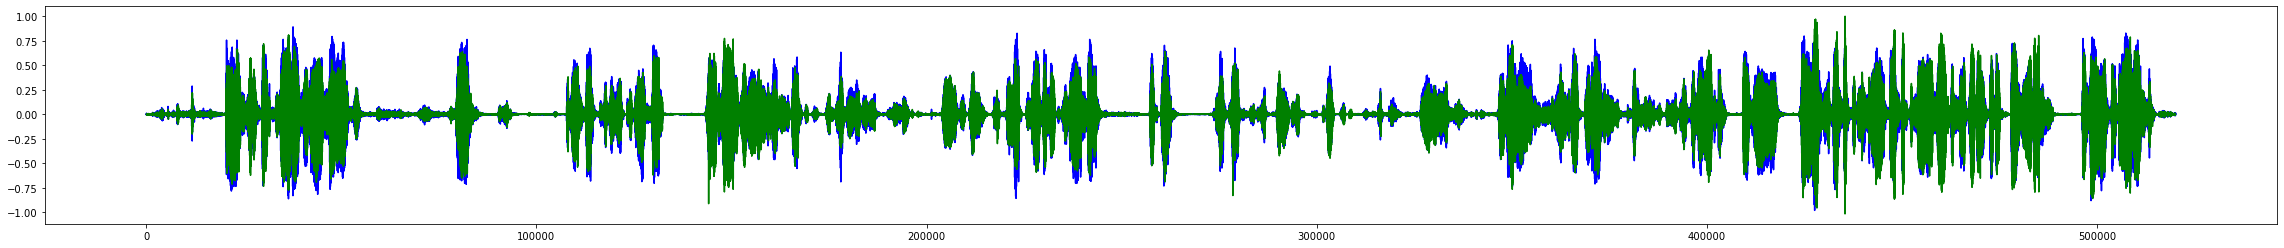

In [52]:
plt.figure(figsize=(40,4))
plt.plot(x,color='blue')
plt.plot(result,color='green')

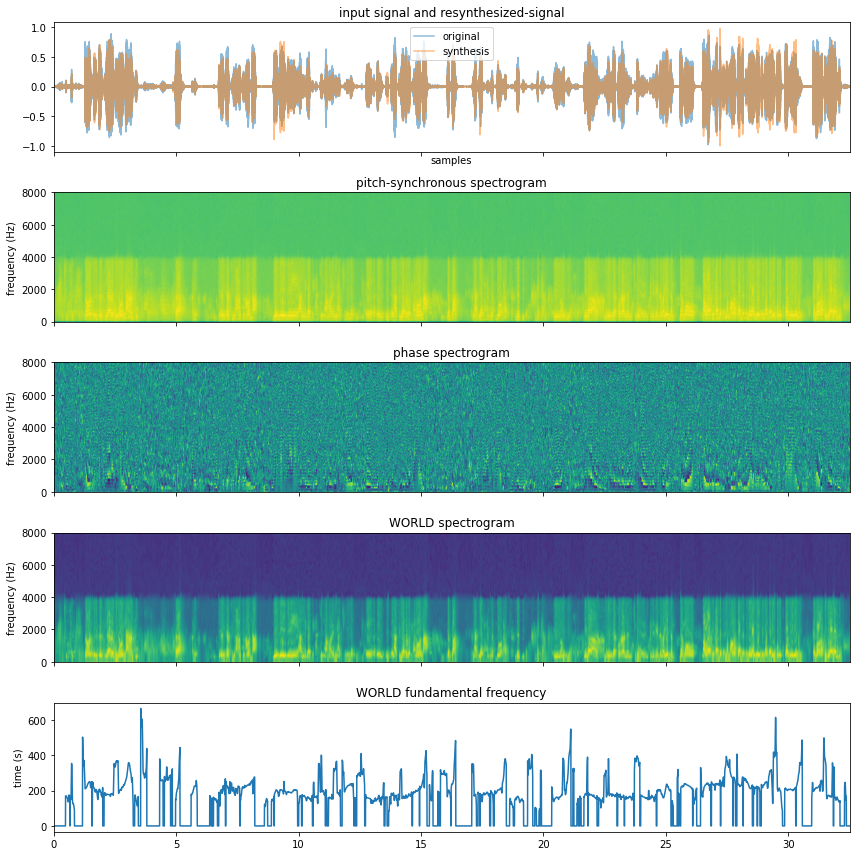

In [41]:
%matplotlib inline
import matplotlib.pylab as plt
vocoder.draw(x, dat, figure_size=(12,12))

In [ ]:
wav_path[0:-4]

output_fn=wav_path[0:-4]+ '-resynth.wav'
wavwrite(output_fn, fs, (dat['out'] * 2 ** 15).astype(np.int16))

output_fn

import IPython
IPython.display.Audio(wav_path)

IPython.display.Audio(output_fn)

from world.get_seeds_signals import get_seeds_signals

ss=get_seeds_signals(dat['fs'])

ss['pulse'].shape

ss['noise'].shape

## Train step 1: Bootstrap from pretrained model

In [ ]:
from Cfg import Cfg
C = Cfg('NIST', 16000, 'amharic', 'build') 

In [ ]:
from load_pretrained_amharic_model import load_pretrained_amharic_model
model = load_pretrained_amharic_model(C, 0)

In [ ]:
import pytorch_lightning as pl
import os, datetime

model_save_dir='save/nemo_amharic'

class ModelCheckpointAtEpochEnd(pl.callbacks.ModelCheckpoint):
    def on_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        metrics['epoch'] = trainer.current_epoch
        trainer.checkpoint_callback.on_validation_end(trainer, pl_module)

pid=os.getpid()
dt=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

checkpoint_callback = ModelCheckpointAtEpochEnd(
    filepath=model_save_dir+'/amharic_'+f'{dt}_{pid}'+'_{epoch:02d}',
    verbose=True,
    save_top_k=-1,
    save_weights_only=False,
    period=1)

trainer = pl.Trainer(gpus=[0], max_epochs=200, amp_level='O1', precision=16, checkpoint_callback=checkpoint_callback)

In [ ]:
from ruamel.yaml import YAML
from omegaconf import DictConfig
config_path = 'amharic_16000.yaml'
yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)
train_manifest=f'{C.build_dir}/train_manifest.json'
test_manifest=f'{C.build_dir}/test_manifest.json'
params['model']['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = test_manifest
model.set_trainer(trainer)
model.setup_training_data(train_data_config=params['model']['train_ds'])
model.setup_validation_data(val_data_config=params['model']['validation_ds'])
model.setup_optimization(optim_config=DictConfig(params['model']['optim']))

In [ ]:
from reshuffle_samples import reshuffle_samples
reshuffle_samples(C)

In [ ]:
trainer.fit(model)

## Apply vocoder filter to DEV

## DEV translation

In [ ]:
from Cfg import Cfg
from glob import glob
from package_DEV import package_DEV
from load_pretrained_amharic_model import load_pretrained_amharic_model
version='113'
C = Cfg('NIST', 16000, 'amharic', 'dev', version)
model = load_pretrained_amharic_model(C, 0)
files=list(sorted(glob(f'{C.audio_split_dir}/*.wav')))
translations=model.transcribe(paths2audio_files=files, batch_size=32)
